# Build a fossil classifier

## Make train and test

In [1]:
ls -l ../fossilnet/*/*/*.jpg | wc | awk '{print $1 " JPEG files"}'

3000 JPEG files


We're not trying to make a fantastic model here, and this is a hard dataset.

So I'm only going to use `train` and `val`, and I'm only going to use 4 classes.

Let's read the files, do a bit of processing on them (make greyscale and resize), and I'll also save a flipped version, so I'll have 2 versions of each image.

In [2]:
import numpy as np

def img_to_arr(img):
    """
    Apply the same processing we used in training: greyscale and resize.
    """
    img = img.convert(mode='L').resize((32, 32))
    return np.asarray(img).ravel() / 255

In [3]:
import os
from glob import glob

from PIL import Image
from collections import defaultdict


sets = ['train', 'val']
classes = ['trilobites', 'fishes', 'forams', 'dinosaurs']

data = defaultdict(list)
labels = defaultdict(list)

for set_ in sets:
    for class_ in classes:
        for fname in glob(f'../fossilnet/{set_}/{class_}/*.jpg'):

            img = Image.open(fname)
            arr = img_to_arr(img)
            data[set_].append(arr.ravel())
            data[set_].append(np.fliplr(arr.reshape(32, 32)).ravel())
            labels[set_] += 2 * [class_]

X_train = np.array(data['train'])
X_val = np.array(data['val'])

y_train = np.array(labels['train'])
y_val = np.array(labels['val'])

In [6]:
X_train.shape

(1600, 1024)

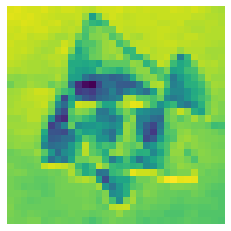

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(data['train'][503].reshape(32, 32))
plt.axis('off')
plt.show()

## Select and evaluate a model

A very simple model, with only 2 hyperparameters to ensure the trees can't overfit.

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=11,
                             max_depth=5,
                             min_samples_leaf=5)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=11)

In [9]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_train)

f1_score(y_train, y_pred, average='weighted')

0.7360526615484191

In [10]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_val)

f1_score(y_val, y_pred, average='weighted')

0.612353043699908

It's a bit overtrained... let's worry about it later. Or maybe it's SEP.

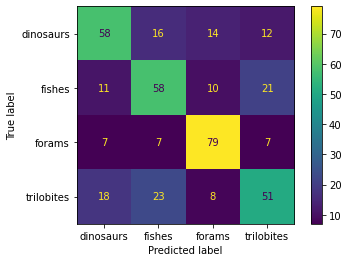

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val)

It's okay at forams, not great at dinos.

## Train the model

Now we can train on all the data so I'll concatenate the arrays together. (We have more data too, as we didn't use the `test` directory, but oh well.

In [12]:
X = np.vstack([X_train, X_val])
y = np.hstack([y_train, y_val])

In [13]:
clf = RandomForestClassifier(random_state=11, max_depth=5, min_samples_leaf=5)

clf.fit(X, y)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=11)

In [12]:
import joblib

joblib.dump(clf, '../app/rf.gz')

['../app/rf.gz']

----

## Make predictions from new images - using URL

We'd like to use this trained model to make predictions from random images people throw at us. So we need a function to process those images to be exactly like the ones we trained on.

Let's stick to using the same tool we used before: `skimage`.

In [13]:
import requests
from io import BytesIO
import numpy as np
import joblib
from PIL import Image

clf = joblib.load('../app/rf.gz')


def fetch_image(url):
    """
    Download an image from the web and pass to the image processing function.
    """
    r = requests.get(url)
    f = BytesIO(r.content)
    return Image.open(f) 

def predict_from_image(clf, img):
    """
    Classify an image.
    """
    arr = img_to_arr(img)
    X = np.atleast_2d(arr)
    probs = clf.predict_proba(X)
    result = {
        'class': clf.classes_[np.argmax(probs)],
        'prob': probs.max(),
        'classes': clf.classes_.tolist(),
        'probs': np.squeeze(probs).tolist(), # Must be serializable.
    }
    return result

In [14]:
with open("examples.txt") as f:
    urls = [l.strip() for l in f.readlines()]

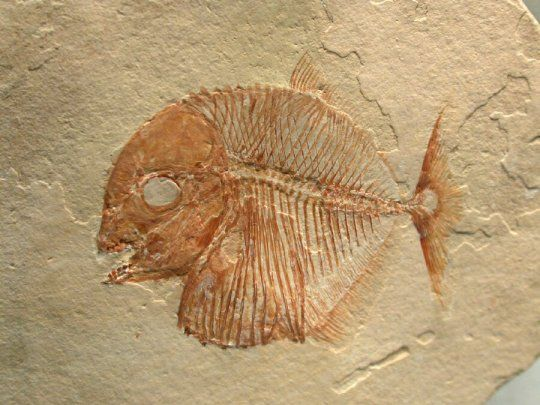

In [15]:
import IPython.display

IPython.display.Image(urls[2])

In [16]:
predict_from_image(clf, fetch_image(urls[2]))

{'class': 'fishes',
 'prob': 0.445330492098426,
 'classes': ['dinosaurs', 'fishes', 'forams', 'trilobites'],
 'probs': [0.15725627357131733,
  0.445330492098426,
  0.05510819101968233,
  0.34230504331057426]}